<a href="https://colab.research.google.com/github/djibril6/djibril6-OptimizationAlgorithms-/blob/main/HGSO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Author**: Djibril ISSOUFOU MAMAN

# Henry Gas Solubility Optimization (HGSO)
Based on the paper: [Henry gas solubility optimization: A novel physics-based algorithm](https://www.sciencedirect.com/science/article/abs/pii/S0167739X19306557)

In [ ]:
#############################
# Requirement
#############################
import numpy as np
import matplotlib.pyplot as plt

import time

# Introduction

Metaheuristic algorithms are computational intelligence paradigms especially used for sophisticated solving optimization problems especially with incomplete or imperfect information or limited computation capacity. There are some metaheuristic algorithm. In this document we present the **Henry gas solubility optimization (HGSO)**.

HGSO is a novel physics-based algorithm that mimics the behavior of Henry’s law.
Based on the paper [Henry gas solubility optimization: A novel physics-based algorithm](https://www.sciencedirect.com/science/article/abs/pii/S0167739X19306557), our proposal python algorithm is evaluated using 6 standard benchmark functions. 

# Benchmark functions

Three benchmark function types will be used: (1) unimodal, (2) multimodal, and (3) fixed-dimension multimodal functions. Lets see the table bellow.

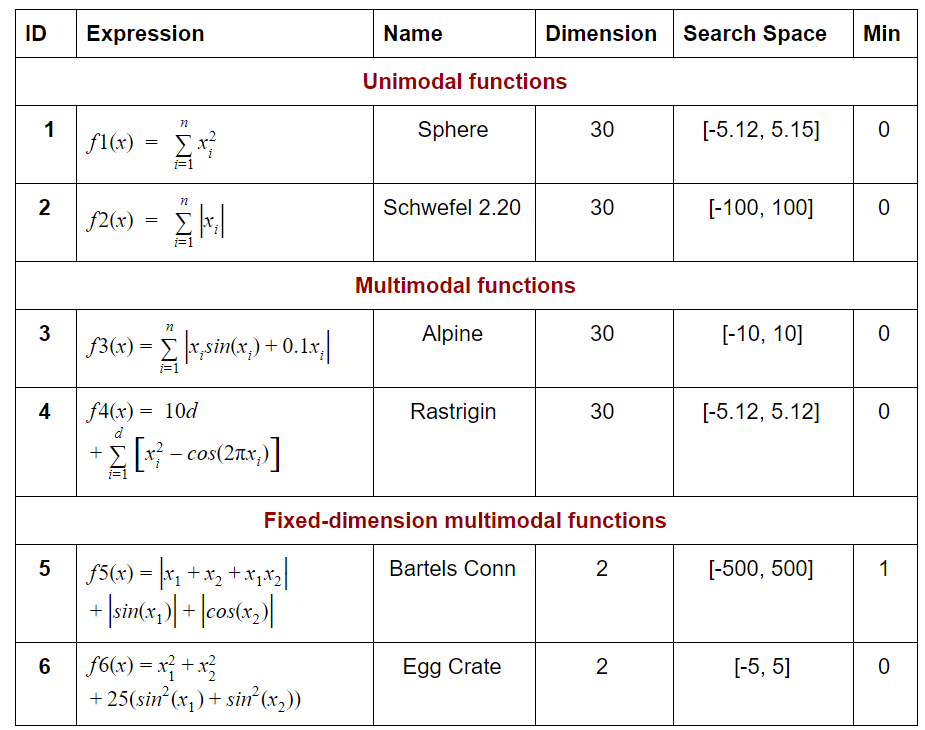

In [ ]:
#################################
# Definition of the functions
#################################
def f1(X):
  if len(X.shape) <= 1:
    return np.sum(X**2)
  return np.sum(X**2, axis=1)

def f2(X):
  if len(X.shape) <= 1:
    return np.sum(np.abs(X))
  return np.sum(np.abs(X), axis=1)

def f3(X):
  if len(X.shape) <= 1:
    return np.sum(np.abs(X * np.sin(X) + .1*X))
  return np.sum(np.abs(X * np.sin(X) + .1*X), axis=1)

def f4(X):
  if len(X.shape) <= 1:
    return 10*X.shape[0] + np.sum(X**2 - 10*np.cos(2*np.pi*X))
  return 10*X.shape[1] + np.sum(X**2 - 10*np.cos(2*np.pi*X), axis=1)

def f5(X):
  x1, x2 = X[0], X[1]
  if len(X.shape) > 1:
    x1, x2 = X[:, 0, :], X[:, 1, :]
  return np.abs(x1 + x2 + x1*x2) + np.abs(np.sin(x1)) + np.abs(np.cos(x2))

def f6(X):
  x1, x2 = X[0], X[1]
  if len(X.shape) > 1:
    x1, x2 = X[:, 0, :], X[:, 1, :]
  return x1**2 + x2**2 + 25*(np.sin(x1)**2 + np.sin(x2)**2)

# Parameter settings

We use N = 50 as a total number of gases in the swarm with 1000 iteration. 
The number of cluster is 5 (5 gas types) where in each cluster, gases have the same Henry’s coefficient value. 

In [ ]:
#### CONFIG ####
N = 50  #==================> Number of gases (population size)
CLUSTER = 5  #=============> Number of gas types (clusters)
ITERATION = 1000 #=========> Number of iterarion 
l1 = 5e-2  #===============> Constant value used for Henry’s coefficient initialisation
l2 = 100  #================> Constant value used for partial pressure initialisation
l3 = 1e-2 #================> Constant value used for enthalpy of dissolution
T0 = 298.15  #=============> The reference temperature
K = 1  #===================> Constant used for solubility
alpha = 1  #===============> The influence of other gases on gas
beta = 1   #===============> Constant used when updating the position of the gas

# **Step1**: Initialization process and Clustering
We have in the first step to initialize the position **X** of the N gases, the 5 Henry’s coefficients **H** (For each cluster), One partial pressure **P** for each gas and one enthalpy of dissolution **C** of each cluster. 
Also, the gases are divided into the 5 group of cluster. Then gases in the same group(cluster) use the same Henry’s coefficient H and enthalpy of dissolution C.

In [ ]:
def initialization(X_min, X_max, DIMENSION, seed=2):
  np.random.seed(seed)
  r = np.random.rand(CLUSTER, DIMENSION, int(N/CLUSTER))
  X = X_min + r*(X_max - X_min)

  H = l1 * np.random.rand(CLUSTER, 1)

  P = l2 * np.random.rand(CLUSTER, int(N/CLUSTER))

  C = l3 * np.random.rand(CLUSTER, 1)
  return X, H, P, C

# **Step2**: Evaluation
We now evaluate each cluster to identify the gas that has the best value in each cluster and the best gas in the total swarm. 

In [ ]:
def evaluate(objective_function, X):
  fitness = objective_function(X)

  _local_best = np.argmin(fitness, axis=1)


  temp = np.where(fitness == np.min(fitness))
  _global_best = (temp[0][0], temp[1][0])

  loc_best_X = []
  for k in range(len(_local_best)):
    loc_best_X.append(X[k, :, _local_best[k]])
  loc_best_X = np.array(loc_best_X)

  glob_best_X = X[_global_best[0], :, _global_best[1]]

  glob_best_X = np.tile(glob_best_X, (X.shape[0], X.shape[2], 1))
  glob_best_X = glob_best_X.reshape((X.shape[0], X.shape[1], X.shape[2]))
  best_fitness = fitness[_global_best]
  return fitness, loc_best_X, glob_best_X, best_fitness

# **Step 3**: Update Henry’s coefficient
Then we change the value of Henry’s coefficient given its last values, the enthalpy of dissolution, the reference temperature the total number of iteration of the algorithm and the current iteration. 

In [ ]:
def update_henry(H, C, T0, iter, iteration):
  return H * np.exp(-C * (1/np.exp(-iter/iteration) - 1/T0))

# **Step 4**: Update solubility 
In this step the solubility is updated using the new Henry’s coefficient, the partial pressure on the gas and constant K

In [ ]:
def update_solubility(H, K, P):
  # Update solubility
  return K * H * P

# **Step 5**: Update position
The position of each gas is then updated with this equation :
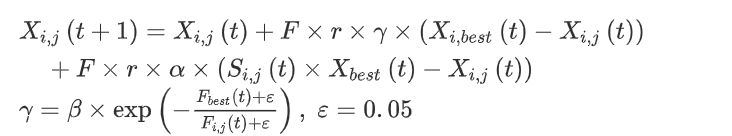


*   **F** is the flag that changes the direction of the search agent 
*   **r** is a random value 
*   alpha is the influence of other gases on gas 
*   beta is a constant
*   Fbest(t) is the best fitness found in the whole swarm
*   F(t) is the fitness of the gas

In [ ]:
def getF():
  # function for gtting the flag F
  values = [-1, 1]
  return values[int(2*np.random.rand()+1)-1]

In [ ]:
def update_position(X, S, fitness, loc_best_X, glob_best_X, best_fitness):
  epsilon = .05
  F = getF()
  gama = beta * np.exp((best_fitness + epsilon) / (fitness + epsilon))
  gama = gama.reshape(X.shape[0],1, X.shape[2])
  loc_best_X = loc_best_X.reshape(X.shape[0], X.shape[1], 1)
  S = S.reshape(X.shape[0],1, X.shape[2])
  r = np.random.rand(X.shape[0], X.shape[1], X.shape[2])
  X = X + F*r*gama*(loc_best_X - X) + F*r*alpha*(S*glob_best_X - X)
  return X

# **Step 6**: Escape from local optimum
This step is used to escape from local optimum. In fact we get the N_w gas with the worst fitness then we reinitialize these gases position.
the number N_w is obtained using: 

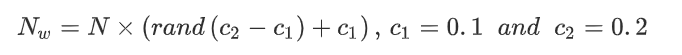

In [ ]:
def worst_agent(objective_function, X, G_min, G_max):
  # Escape from local optimum and Update the position of the worst agents.
    c1, c2 = .1, .2
    N_w = int(X.shape[0]*X.shape[2] * (np.random.rand()*(c2 - c1) + c1))

    # Get the N_w worst agents
    fitness = objective_function(X)
    flat = fitness.flatten()
    indices = np.argpartition(flat, -N_w)[-N_w:]
    indices = indices[np.argsort(-flat[indices])]
    worst_indices = np.unravel_index(indices, fitness.shape)
    
    # Update worst agent
    r = np.random.rand(X.shape[1])
    for k in range(N_w):
      X[worst_indices[0][k], :, worst_indices[1][k]] = G_min + r*(G_max - G_min)
    
    fitness, _, _, _ = evaluate(objective_function, X)
    return X, fitness

# Build the algoritm

In [ ]:
def HGSO(objective_function, X, X_min, X_max, H, C, P, K, fitness, loc_best_X, glob_best_X, best_fitness, T0, iter, ITERATION):
    # Update Henry’s coefficient
    H = update_henry(H, C, T0, iter, ITERATION)

    # Update solubility
    S = update_solubility(H, K, P)

    # update position
    X = update_position(X, S, fitness, loc_best_X, glob_best_X, best_fitness)

    # Get the best solution in the swarm
    fitness, loc_best_X, t_glob_best_X, t_best_fitness = evaluate(objective_function, X)
    if t_best_fitness < best_fitness:
      best_fitness = t_best_fitness
      glob_best_X = t_glob_best_X

    # Escape from local optimum and Update the position of the worst agents.
    G_min, G_max = X_min, X_max
    X, fitness = worst_agent(objective_function, X, G_min, G_max)
    return X, fitness, loc_best_X, glob_best_X, best_fitness

In [ ]:
def main(objective_function, dimension, X_min, X_max):
  the_best = []
  X, H, P, C = initialization(X_min, X_max, dimension)
  fitness, loc_best_X, glob_best_X, best_fitness = evaluate(objective_function, X)

  tic = time.time()
  for iter in range(1, ITERATION+1):
    X, fitness, loc_best_X, glob_best_X, best_fitness = HGSO(objective_function, X, -10, 10, H, C, P, K, fitness, loc_best_X, glob_best_X, best_fitness, T0, iter, ITERATION)
    the_best.append(best_fitness)

  toc = time.time()
  print("###############################################")
  print("Computation time: {:f} seconds".format(toc-tic))
  print("Best optimization found is {:e}".format(the_best[-1]))
  print("###############################################")
  plt.suptitle("Convergence")
  plt.plot(the_best)

### Run the algorithm for the 1st function 


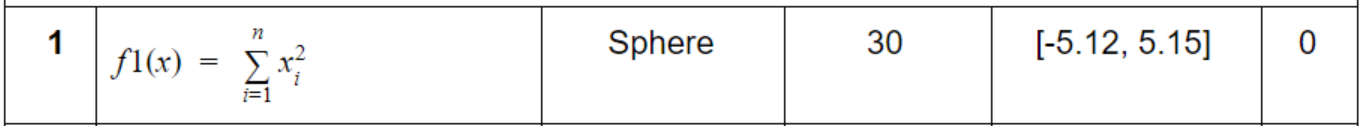

###############################################
Computation time: 0.271522 seconds
Best optimization found is 3.595333e-171
###############################################


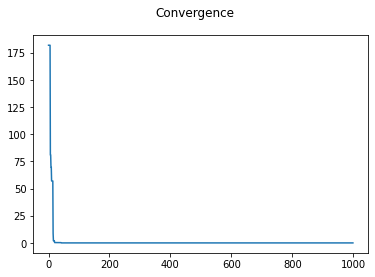

In [ ]:
main(objective_function=f1, dimension=30, X_min=-5.12, X_max=5.12)

### Run the algorithm for the 2nd function

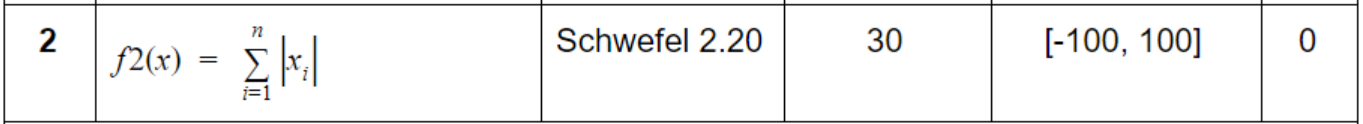

###############################################
Computation time: 0.278946 seconds
Best optimization found is 1.734118e-89
###############################################


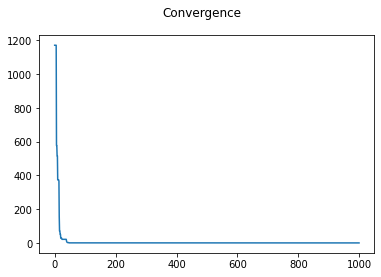

In [ ]:
main(objective_function=f2, dimension=30, X_min=-100, X_max=100)

### Run the algorithm for the 3rd function

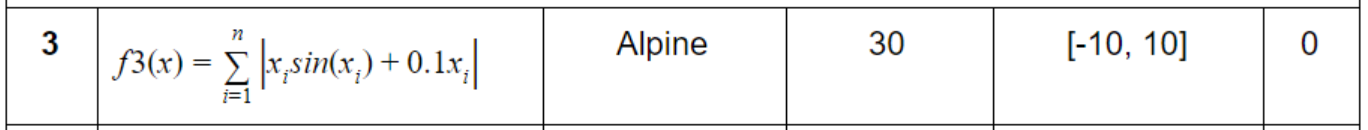

###############################################
Computation time: 0.399643 seconds
Best optimization found is 2.074656e-104
###############################################


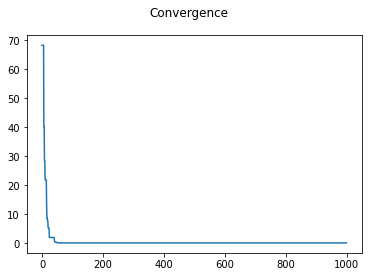

In [ ]:
main(objective_function=f3, dimension=30, X_min=-10, X_max=10)

### Run the algorithm for the 6th function

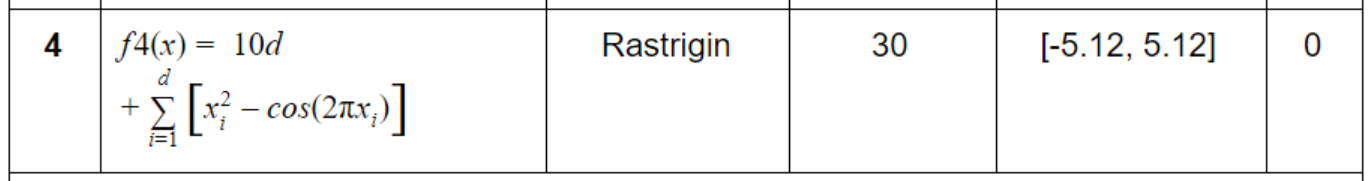

###############################################
Computation time: 0.431561 seconds
Best optimization found is 0.000000e+00
###############################################


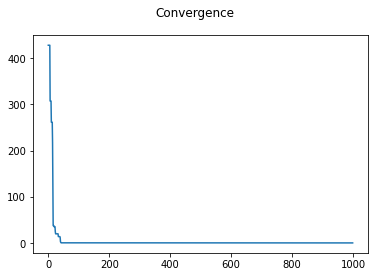

In [ ]:
main(objective_function=f4, dimension=30, X_min=-5.12, X_max=5.12)

### Run the algorithm for the 5th function 

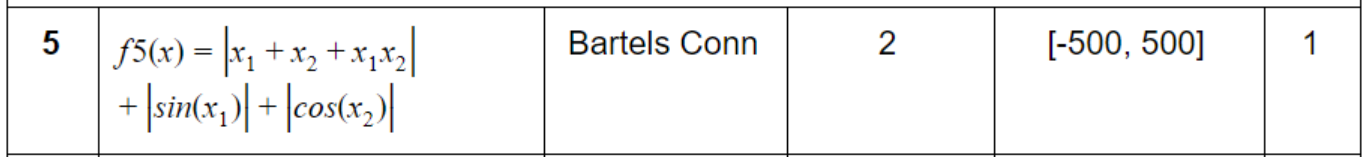

###############################################
Computation time: 0.245974 seconds
Best optimization found is 1.713405e-01
###############################################


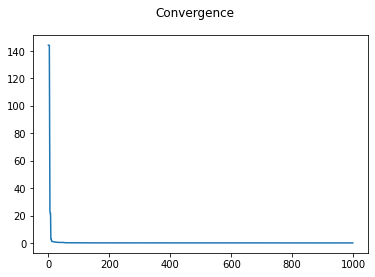

In [ ]:
main(objective_function=f5, dimension=2, X_min=-500, X_max=500)

### Run the algorithm for the 6th function 

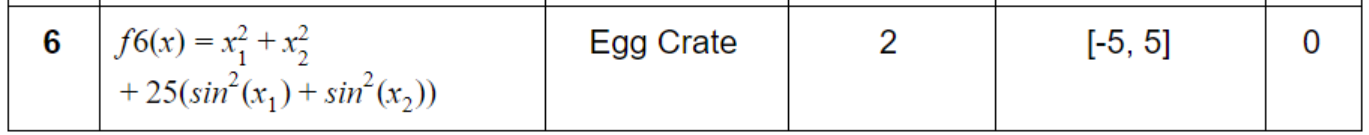

###############################################
Computation time: 0.250489 seconds
Best optimization found is 5.746812e-184
###############################################


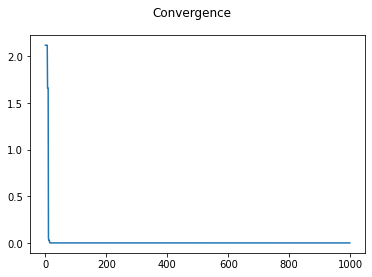

In [ ]:
main(objective_function=f6, dimension=2, X_min=-5, X_max=5)

## Summarization:


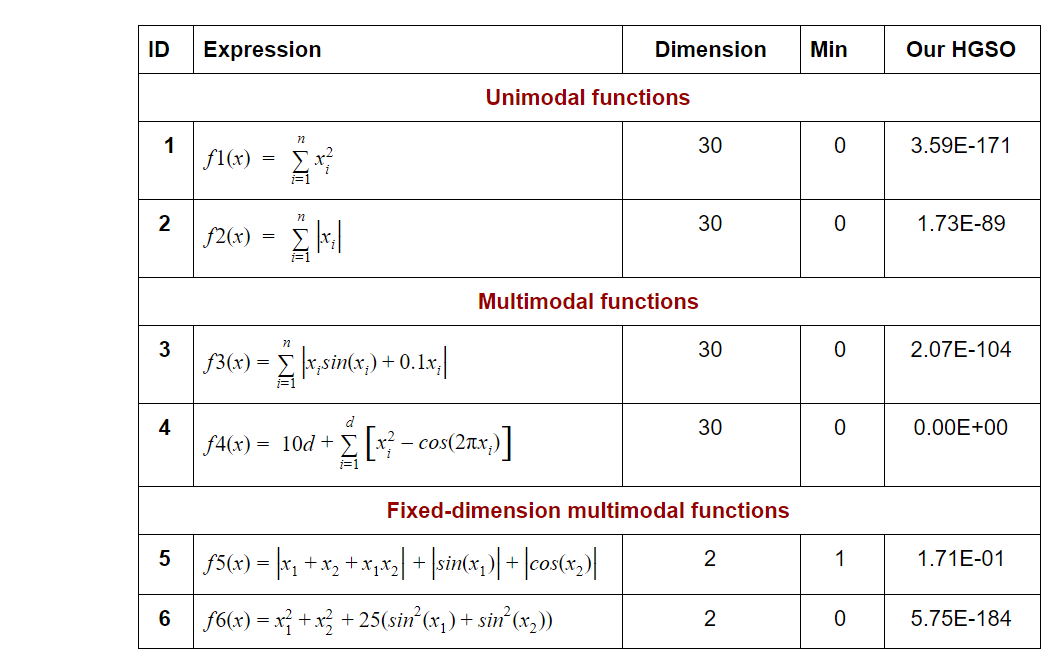

# Conclusion
As we can see the Henry Gas Solubility Optimization algorithm performs well. It able to escape from local optimum and compute relatively fast. Also it is important to not that the result can change with different value of seed.